Importing necessary libraries

In [1]:
import keras
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,LSTM,Input,Bidirectional
from sklearn.model_selection import cross_val_score 
from nltk.tokenize import word_tokenize,sent_tokenize
from ast import literal_eval
import nltk
from keras.layers import *
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df=pd.read_csv('/content/drive/My Drive/MLProject_CS5439/isear.csv',header=None)
print(len(df))

7652


Drop the rows which contains "No response".

In [4]:
df.drop(df[df[1] == '[ No response.]'].index, inplace = True)
print(len(df))

7575


It will store the sentences that people have said which demonstrate their feelings.




In [5]:
feel_arr=df[1]
feel_arr[0]

'[ On days when I feel close to my partner and other friends.  \nWhen I feel at peace with myself and also experience a close \ncontact with people whom I regard greatly.]'

In [36]:
a= df[0].unique()
print(a)

['joy' 'fear' 'anger' 'sadness' 'disgust' 'shame' 'guilt']


Now, each sentence in fee_arr has been tokenised into words. Like "hi i am here" is converted to ["hi","i","am","here"] and now stored in feel_arr

In [6]:
feel_arr=[word_tokenize(sent) for sent in feel_arr]
print(feel_arr[0])

['[', 'On', 'days', 'when', 'I', 'feel', 'close', 'to', 'my', 'partner', 'and', 'other', 'friends', '.', 'When', 'I', 'feel', 'at', 'peace', 'with', 'myself', 'and', 'also', 'experience', 'a', 'close', 'contact', 'with', 'people', 'whom', 'I', 'regard', 'greatly', '.', ']']


As the length of sentence vary, but input to LSTM will be a fixed length of sentence, so here I have chosed 100 words as my sentence length. So when, the sentence will contains more than 100 words, padd function will discard the words after 100th position. If the sentence will have less than 100 words, so rest of the array will be filled with 'pad' word.

In [7]:
def padd(arr):
    for i in range(100-len(arr)):
        arr.append('<pad>')
    return arr[:100]
for i in range(len(feel_arr)):
  feel_arr[i]=padd(feel_arr[i])

Initialising glove array which contains a large amounts of words and their corresponding vector representaion in 300 dimensions.For each word in feel_arr we will have a glove vector of 300 dimensions

In [ ]:
vocab_f ='/content/drive/My Drive/glove.840B.300d.txt'

In [8]:
vocab_f ='/content/drive/My Drive/MLProject_CS5439/glove.6B.50d.txt'

In [9]:
embeddings_index = {}
with open(vocab_f,encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [10]:
embeddings_index['<pad>']=[0]*50
print(len(embeddings_index['happy']))

50


Each word of each sentence has been embedded into glove vector of size 300.

In [11]:
embedded_feel_arr=[] 
for each_sentence in feel_arr:
    embedded_feel_arr.append([])
    for word in each_sentence:
        if word.lower() in embeddings_index:
            embedded_feel_arr[-1].append(embeddings_index[word.lower()])
        else:
            embedded_feel_arr[-1].append([0]*50)
print(embedded_feel_arr[0][0])

[-0.61201   0.98226   0.11539   0.014623  0.23873  -0.067035  0.30632
 -0.64742  -0.38517  -0.03691   0.094788  0.57631  -0.091557 -0.54825
  0.25255  -0.14759   0.13023   0.21658  -0.30623   0.30028  -0.23471
 -0.17927   0.9518    0.54258   0.31172  -0.51038  -0.65223  -0.48858
  0.13486  -0.40132   2.493    -0.38777  -0.26456  -0.49414  -0.3871
 -0.20983   0.82941  -0.46253   0.39549   0.014881  0.79485  -0.79958
 -0.16243   0.013862 -0.53536   0.52536   0.019818 -0.16353   0.30649
  0.81745 ]


Changing into numpy array

In [12]:
X=np.array(embedded_feel_arr)
print(np.shape(X))

(7575, 100, 50)


Encoding the categorical data i.e Emotions using OneHotEncoder

In [33]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
Y = onehotencoder.fit_transform(np.array(df[0]).reshape(-1,1)).toarray()
print(np.shape(Y))

(7575, 7)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

Implementing the BiLSTM model

In [15]:
def BiLSTMModel(X,Y,input_size1,input_size2,output_size):
  m=Sequential()
  m.add(Bidirectional(LSTM(100,input_shape=(input_size1,input_size2))))
  m.add(Dropout(0.5))
  m.add(Dense(output_size,activation='softmax'))
  m.compile('Adam','categorical_crossentropy',['accuracy'])
  m.fit(X,Y,epochs=20, batch_size=128)
  return m

In [16]:
bilstmModel=BiLSTMModel(X_train,Y_train,100,50,7)

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
bilstmModel.evaluate(X_test,Y_test)

24/24 [==============================] - 0s 11ms/step - loss: 1.3604 - accuracy: 0.6214


[1.3604387044906616, 0.6213720440864563]

In [ ]:
def CNNModel(X,Y,input_size1,input_size2,output_size):
  model1 = Sequential()
  model1.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=[input_size1, input_size2]))
  model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model1.add(Dropout(0.5))
  model1.add(MaxPooling1D(pool_size=2))
  model1.add(Flatten())
  model1.add(Dense(100, activation='relu'))
  model1.add(Dense(output_size, activation='softmax'))
  model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model1.fit(X,Y,epochs=20)
  return model1

In [ ]:
cnnModel=CNNModel(X_train,Y_train,100,300,7)

Epoch 1/20
214/214 [==============================] - 1s 6ms/step - loss: 1.8122 - accuracy: 0.2668
Epoch 2/20
214/214 [==============================] - 1s 5ms/step - loss: 1.4185 - accuracy: 0.4602
Epoch 3/20
214/214 [==============================] - 1s 5ms/step - loss: 1.1552 - accuracy: 0.5703
Epoch 4/20
214/214 [==============================] - 1s 5ms/step - loss: 0.9793 - accuracy: 0.6403
Epoch 5/20
214/214 [==============================] - 1s 5ms/step - loss: 0.8266 - accuracy: 0.7022
Epoch 6/20
214/214 [==============================] - 1s 5ms/step - loss: 0.7340 - accuracy: 0.7292
Epoch 7/20
214/214 [==============================] - 1s 5ms/step - loss: 0.5927 - accuracy: 0.7874
Epoch 8/20
214/214 [==============================] - 1s 5ms/step - loss: 0.5646 - accuracy: 0.7973
Epoch 9/20
214/214 [==============================] - 1s 5ms/step - loss: 0.4359 - accuracy: 0.8416
Epoch 10/20
214/214 [==============================] - 1s 5ms/step - loss: 0.3479 - accuracy: 0.8741

In [ ]:
cnnModel.evaluate(X_test,Y_test)

24/24 [==============================] - 0s 7ms/step - loss: 2.3495 - accuracy: 0.5660


[2.349514961242676, 0.565963089466095]

In [17]:
def SENNModel(X,Y,input_size1,input_size2,output_size):
    first_input = Input(shape=[input_size1,input_size2])
    cnn=Conv1D(256,3, activation='relu')(first_input)
    cnn1=Conv1D(256,3, activation='relu')(cnn)
    d1=Dropout(0.5)(cnn1)
    gm=GlobalMaxPooling1D()(d1)
    out1=Dense(32,activation='relu')(gm)
    second_input = Input(shape=[input_size1,input_size2])
    BiLSTM=Bidirectional(LSTM(100,input_shape=[input_size1,input_size2]))(second_input)
    d2=Dropout(0.5)(BiLSTM)
    out2=Dense(32,activation='relu')(d2)
    merged=Concatenate()([out1,out2])
    print(type(merged))
    out=Dense(output_size,activation='softmax')(merged)
    m=Model(inputs=[first_input,second_input], outputs=out)
    m.compile('Adam','categorical_crossentropy',['accuracy'])
    m.fit([X,X],Y,epochs=20,batch_size=128)
    return m

In [19]:
sennModel=SENNModel(X_train,Y_train,100,50,7)

<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
Epoch 1/20
54/54 [==============================] - 4s 27ms/step - loss: 1.9762 - accuracy: 0.2006
Epoch 2/20
54/54 [==============================] - 1s 22ms/step - loss: 1.6084 - accuracy: 0.3974
Epoch 3/20
54/54 [==============================] - 1s 23ms/step - loss: 1.3953 - accuracy: 0.4921
Epoch 4/20
54/54 [==============================] - 1s 23ms/step - loss: 1.2513 - accuracy: 0.5547
Epoch 5/20
54/54 [==============================] - 1s 22ms/step - loss: 1.1725 - accuracy: 0.5858
Epoch 6/20
54/54 [==============================] - 1s 23ms/step - loss: 1.1053 - accuracy: 0.6036
Epoch 7/20
54/54 [==============================] - 1s 22ms/step - loss: 1.0246 - accuracy: 0.6286
Epoch 8/20
54/54 [==============================] - 1s 23ms/step - loss: 0.9823 - accuracy: 0.6498
Epoch 9/20
54/54 [==============================] - 1s 22ms/step - loss: 0.9109 - accuracy: 0.6767
Epoch 10/20
54/54 [========================

In [20]:
sennModel.evaluate([X_test,X_test],Y_test)

24/24 [==============================] - 1s 12ms/step - loss: 1.2698 - accuracy: 0.5567


[1.269766092300415, 0.5567282438278198]

In [ ]:
Y_Pred=sennModel.predict([X_test,X_test])
print(Y_Pred[0])

[0.00162659 0.00156472 0.00438142 0.2592242  0.00315464 0.00443657
 0.7256118 ]


In [45]:
def prepare(s):
  s=word_tokenize(s)
  #print("s= ",s)
  k=padd(s)
  embedded_arr=[]
  embedded_arr.append([])
  for word in k:
        if word.lower() in embeddings_index:
            embedded_arr[-1].append(embeddings_index[word.lower()])
        else:
            embedded_arr[-1].append([0]*50)
  x_input=np.array(embedded_arr)
  #print(np.shape(x_input))
  arr = sennModel.predict([x_input,x_input])
  return arr.argmax()
k=input()
print(prepare(k))

i am sad
5


In [ ]:
round_preds = np.around(Y_Pred)
print(round_preds[0])

[0. 0. 0. 0. 0. 0. 1.]


In [ ]:
class_preds = np.argmax(round_preds, axis=-1)
print(class_preds[:10])

[6 0 0 1 6 4 1 6 0 4]


In [ ]:
Y_test=np.argmax(Y_test, axis=-1)
print(len(Y_test))

758


In [ ]:
print(Y_test[:10])

[6 2 0 1 3 4 2 6 0 4]


In [31]:
sennModel.save('/content/drive/MyDrive/senn_model.h5')

In [ ]:
from sklearn.metrics import confusion_matrix
cf=confusion_matrix(Y_test,class_preds)
print(cf)

[[80  5  0 10  1  1 11]
 [19 50  8  5  3  3 14]
 [17  7 59  4  2  1  6]
 [28  3  4 58  4  2 14]
 [11  0  3  0 97  2  4]
 [26  3  3  9 14 52  7]
 [16  4  5 16  5  2 60]]


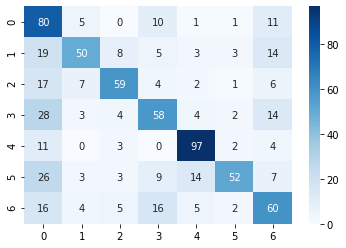

In [ ]:
import seaborn as sns
sns.heatmap(cf, annot=True,cmap='Blues',fmt="d")

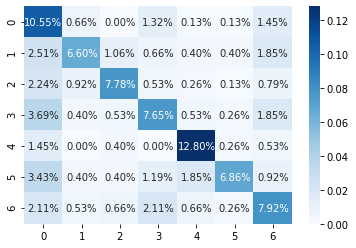

In [ ]:
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,class_preds)

0.6015831134564644

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(Y_test,class_preds)
print(report)

              precision    recall  f1-score   support

           0       0.41      0.74      0.52       108
           1       0.69      0.49      0.57       102
           2       0.72      0.61      0.66        96
           3       0.57      0.51      0.54       113
           4       0.77      0.83      0.80       117
           5       0.83      0.46      0.59       114
           6       0.52      0.56      0.54       108

    accuracy                           0.60       758
   macro avg       0.64      0.60      0.60       758
weighted avg       0.64      0.60      0.60       758

